In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import gc
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import TFRobertaModel, RobertaTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Enable mixed precision
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Load and preprocess data
df = pd.read_csv('/kaggle/input/ai-txt-detection-traindataset/train_set.csv')
df = df.dropna(subset=['text'])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Fill NaN values in additional features
features = ['avg line length', 'word density', 'mean_perplexity', 'burstiness1', 'flesch_kincaid_score', 'gunning_fog_score']
for feature in features:
    df[feature].fillna(df[feature].mean(), inplace=True)

# Separate features and labels
texts = df['text'].tolist()
additional_features = df[features].values
labels = df['label'].tolist()

# Clear DataFrame from memory
del df
gc.collect()

# Scale additional features
scaler = StandardScaler()
additional_features = scaler.fit_transform(additional_features)

# Load tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base")

MAX_SEQ_LENGTH = 512

# Tokenize function
def batch_tokenize(texts, tokenizer, batch_size=32, max_length=MAX_SEQ_LENGTH):
    input_ids_list, attention_mask_list = [], []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
        input_ids_list.append(inputs['input_ids'])
        attention_mask_list.append(inputs['attention_mask'])
        gc.collect()
    return tf.concat(input_ids_list, axis=0), tf.concat(attention_mask_list, axis=0)

# Tokenize texts
input_ids, attention_masks = batch_tokenize(texts, tokenizer)

# Convert to NumPy arrays
input_ids = input_ids.numpy()
attention_masks = attention_masks.numpy()
labels = np.array(labels)

# Clear texts from memory
del texts
gc.collect()

# Split the data into train and test sets
train_inputs, test_inputs, train_masks, test_masks, train_features, test_features, train_labels, test_labels = train_test_split(
    input_ids, attention_masks, additional_features, labels, test_size=0.2, random_state=42
)

# Save test_labels as numpy array before clearing
test_labels_numpy = test_labels

# Clear original arrays from memory
del input_ids, attention_masks, additional_features, labels
gc.collect()

# Convert to TensorFlow tensors
train_inputs = tf.convert_to_tensor(train_inputs)
test_inputs = tf.convert_to_tensor(test_inputs)
train_masks = tf.convert_to_tensor(train_masks)
test_masks = tf.convert_to_tensor(test_masks)
train_features = tf.convert_to_tensor(train_features, dtype=tf.float32)
test_features = tf.convert_to_tensor(test_features, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.int32)

# Model definition
class RoBERTaWithAdditionalFeatures(tf.keras.Model):
    def __init__(self, roberta_model, num_additional_features, num_classes, dropout_rate):
        super().__init__()
        self.roberta = roberta_model
        self.num_additional_features = num_additional_features
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.additional_features_layer = tf.keras.layers.Dense(768, activation='relu', kernel_regularizer=l2(1e-5))
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.concat_layer = tf.keras.layers.Concatenate()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='sigmoid', kernel_regularizer=l2(1e-5))

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        additional_features = inputs['additional_features']

        roberta_output = self.roberta(input_ids, attention_mask=attention_mask)[1]
        additional_features = self.additional_features_layer(additional_features)
        additional_features = self.dropout(additional_features)
        concatenated = self.concat_layer([roberta_output, additional_features])
        output = self.classifier(concatenated)
        return output
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_additional_features": self.num_additional_features,
            "num_classes": self.num_classes,
            "dropout_rate": self.dropout_rate,
        })
        return config

    @classmethod
    def from_config(cls, config, custom_objects=None):
        roberta_model = TFRobertaModel.from_pretrained("roberta-base")
        return cls(roberta_model=roberta_model, **config)

# Adjusted hyperparameters
learning_rate = 35e-4
epochs = 10
dropout_rate = 0.2

# Learning rate schedule
def lr_schedule(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return float(lr * tf.math.exp(-0.05))

# Create datasets with reduced batch size
BATCH_SIZE = 8
train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_inputs, "attention_mask": train_masks, "additional_features": train_features},
    train_labels
)).shuffle(1000).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": test_inputs, "attention_mask": test_masks, "additional_features": test_features},
    test_labels
)).batch(BATCH_SIZE)

# Clear individual tensors from memory
del train_inputs, test_inputs, train_masks, test_masks, train_features, test_features, train_labels, test_labels
gc.collect()

# Model definition and compilation
model = RoBERTaWithAdditionalFeatures(roberta_model, num_additional_features=6, num_classes=1, dropout_rate=dropout_rate)
optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)
model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), 
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall')])

# Callbacks
class CustomValidationCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.val_losses = []
        self.val_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_logs = self.model.evaluate(self.validation_data, verbose=0)
        if val_logs is not None:
            for name, value in zip(self.model.metrics_names, val_logs):
                logs[f'val_{name}'] = value
            self.val_losses.append(val_logs[0])
            self.val_accuracies.append(val_logs[1])

# Use this callback instead of directly passing validation_data to fit
custom_validation = CustomValidationCallback(test_dataset)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lr_schedule)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=[custom_validation, early_stopping, lr_scheduler, reduce_lr]
)

# Evaluate the model
eval_result = model.evaluate(test_dataset)
print("Evaluation result:", eval_result)

# Unpack the results
test_loss, test_accuracy, test_auc, test_precision, test_recall = eval_result
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Make predictions
predictions = model.predict(test_dataset)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Save the model
@tf.function(input_signature=[
    tf.TensorSpec(shape=[None, 512], dtype=tf.int32, name='input_ids'),
    tf.TensorSpec(shape=[None, 512], dtype=tf.int32, name='attention_mask'),
    tf.TensorSpec(shape=[None, 6], dtype=tf.float32, name='additional_features')
])
def serving_function(input_ids, attention_mask, additional_features):
    inputs = {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'additional_features': additional_features
    }
    outputs = model(inputs, training=False)
    return outputs

# Save the model with the serving function
model_path = 'ai_text_detection_model_robertaModel_saved'
tf.saved_model.save(model, model_path, signatures={'serving_default': serving_function})
print(f"Model saved successfully with serving function as '{model_path}'.")


2024-07-18 09:50:28.932989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 09:50:28.933083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 09:50:29.064310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_34/3767580080.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

   1/4296 ━━━━━━━━━━━━━━━━━━━━ 24:50:22 21s/step - accuracy: 0.3750 - auc: 0.3125 - loss: 0.7144 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1721296668.055263     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721296668.099284     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4296/4296 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9078 - auc: 0.9674 - loss: 0.2326 - precision: 0.9061 - recall: 0.9085

W0000 00:00:1721297271.250864     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721297278.328247     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4296/4296 ━━━━━━━━━━━━━━━━━━━━ 775s 176ms/step - accuracy: 0.9078 - auc: 0.9674 - loss: 0.2325 - precision: 0.9061 - recall: 0.9085 - val_loss: 0.1641 - val_compile_metrics: 0.9413 - learning_rate: 0.0035
Epoch 2/10
4296/4296 ━━━━━━━━━━━━━━━━━━━━ 738s 172ms/step - accuracy: 0.9498 - auc: 0.9886 - loss: 0.1438 - precision: 0.9455 - recall: 0.9542 - val_loss: 0.1293 - val_compile_metrics: 0.9604 - learning_rate: 0.0035
Epoch 3/10
4296/4296 ━━━━━━━━━━━━━━━━━━━━ 737s 172ms/step - accuracy: 0.9580 - auc: 0.9916 - loss: 0.1274 - precision: 0.9545 - recall: 0.9617 - val_loss: 0.1270 - val_compile_metrics: 0.9601 - learning_rate: 0.0033
Epoch 4/10
4296/4296 ━━━━━━━━━━━━━━━━━━━━ 740s 172ms/step - accuracy: 0.9610 - auc: 0.9922 - loss: 0.1229 - precision: 0.9560 - recall: 0.9657 - val_loss: 0.1148 - val_compile_metrics: 0.9669 - learning_rate: 0.0032
Epoch 5/10
4296/4296 ━━━━━━━━━━━━━━━━━━━━ 742s 172ms/step - accuracy: 0.9634 - auc: 0.9934 - loss: 0.1169 - precision: 0.9597 - recall: 0.9672 - va

W0000 00:00:1721304245.741297     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1074/1074 ━━━━━━━━━━━━━━━━━━━━ 146s 132ms/step
Model saved successfully with serving function as 'ai_text_detection_model_robertaModel_saved'.


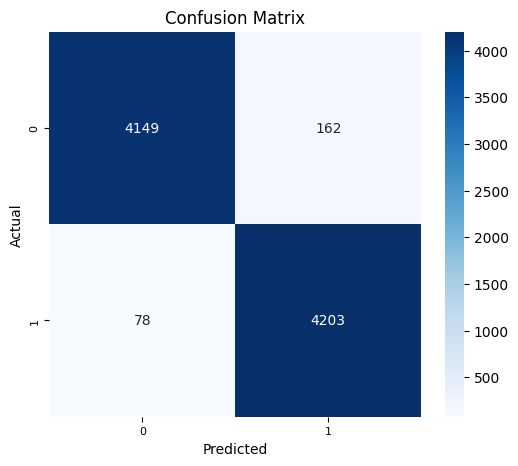

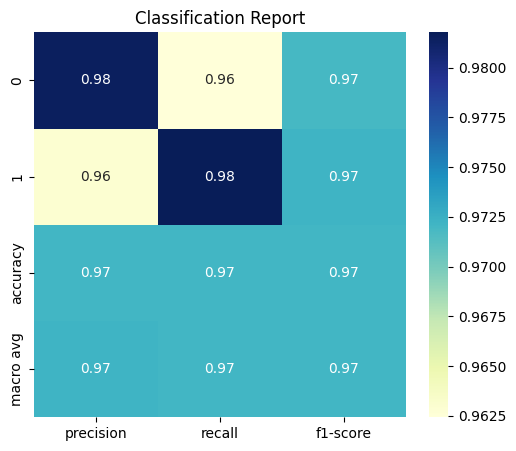

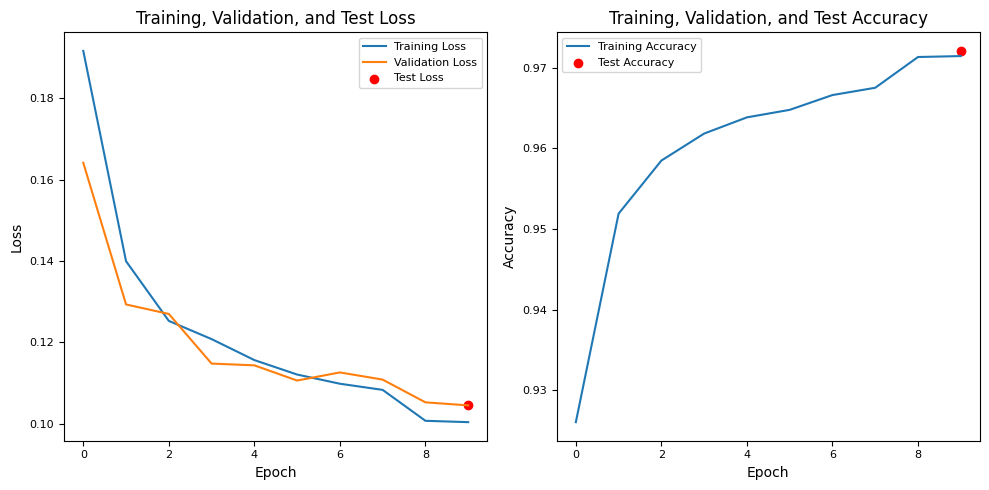

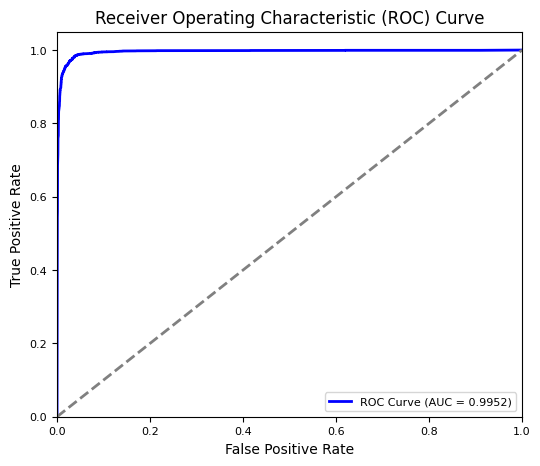

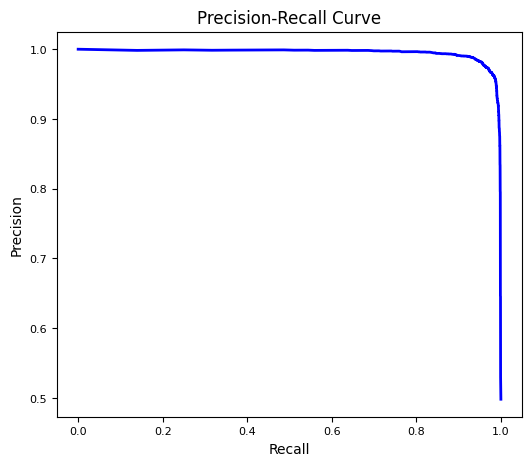

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


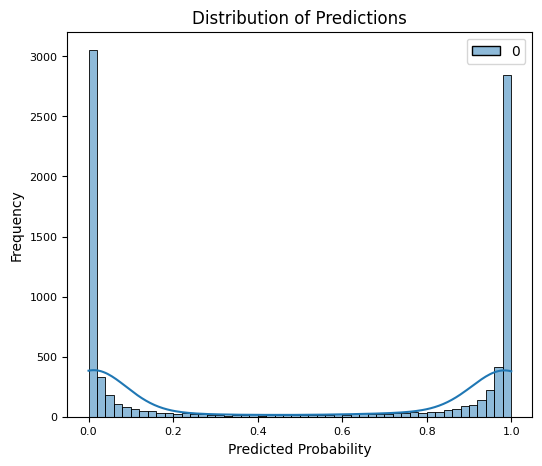

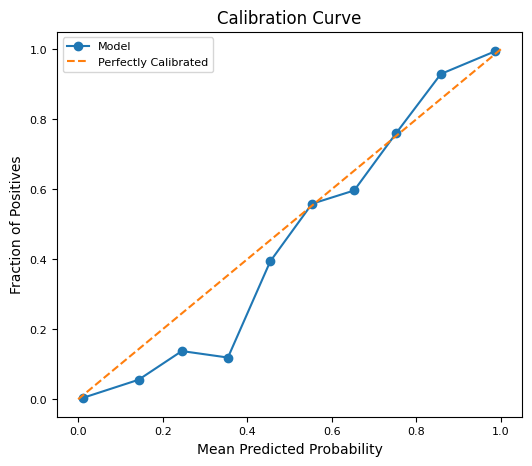

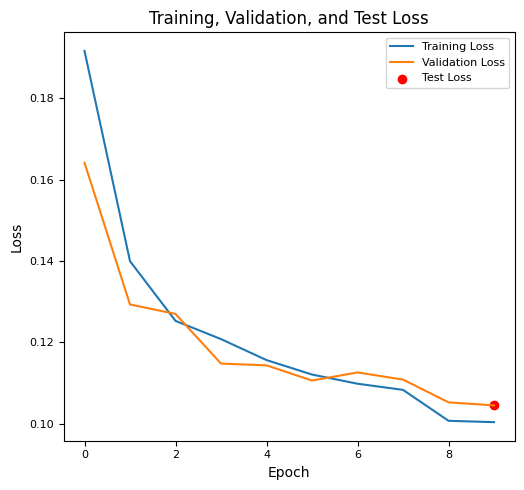

In [2]:
###smaller plots for ppt

# Confusion Matrix
cm = confusion_matrix(test_labels_numpy, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 10})
plt.title('Confusion Matrix', fontsize=12)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

# Classification Report
report = classification_report(test_labels_numpy, predicted_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()
plt.figure(figsize=(6, 5))
sns.heatmap(df_report.iloc[:-1, :].drop('support', axis=1).astype(float), annot=True, cmap='YlGnBu', annot_kws={"size": 10})
plt.title('Classification Report', fontsize=12)
plt.show()

# Training History with Test Results
plt.figure(figsize=(10, 5))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.scatter(len(history.history['loss'])-1, test_loss, color='red', label='Test Loss')
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Training, Validation, and Test Loss', fontsize=12)
plt.legend(fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.scatter(len(history.history['accuracy'])-1, test_accuracy, color='red', label='Test Accuracy')
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Training, Validation, and Test Accuracy', fontsize=12)
plt.legend(fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

# ROC Curve and AUC Score
plt.figure(figsize=(6, 5))
fpr, tpr, _ = roc_curve(test_labels_numpy, predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=12)
plt.legend(loc='lower right', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(6, 5))
precision, recall, _ = precision_recall_curve(test_labels_numpy, predictions)
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall', fontsize=10)
plt.ylabel('Precision', fontsize=10)
plt.title('Precision-Recall Curve', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

# Convert predictions to float32
predictions = predictions.astype('float32')

# Plotting Distribution of Predictions
plt.figure(figsize=(6, 5))
sns.histplot(predictions, bins=50, kde=True)
plt.xlabel('Predicted Probability', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.title('Distribution of Predictions', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

# Calibration Curve
prob_true, prob_pred = calibration_curve(test_labels_numpy, predictions, n_bins=10)
plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability', fontsize=10)
plt.ylabel('Fraction of Positives', fontsize=10)
plt.title('Calibration Curve', fontsize=12)
plt.legend(fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

# Learning Curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.scatter(len(history.history['loss'])-1, test_loss, color='red', label='Test Loss')
plt.title('Training, Validation, and Test Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


In [3]:
import shutil

# Zip the saved model directory
shutil.make_archive('/kaggle/working/ai_txt_detection_robertaModel_epoch10EarlyFeatures', 'zip', '/kaggle/working/ai_text_detection_model_robertaModel_saved')
print("Model zipped successfully as 'ai_txt_detection_robertaModel_epoch10EarlyFeatures.zip'.")

Model zipped successfully as 'ai_txt_detection_robertaModel_epoch10EarlyFeatures.zip'.


In [4]:
from IPython.display import FileLink

FileLink(r'ai_txt_detection_robertaModel_epoch10EarlyFeatures.zip')

/kaggle/working/ai_txt_detection_robertaModel_epoch10EarlyFeatures.zip

In [6]:
# Check the size of the zip file
!du -sh ai_txt_detection_robertaModel_epoch10EarlyFeatures.zip

283M	ai_txt_detection_robertaModel_epoch10EarlyFeatures.zip


In [7]:
print("Train dataset size:", tf.data.experimental.cardinality(train_dataset).numpy())
print("Test dataset size:", tf.data.experimental.cardinality(test_dataset).numpy())

Train dataset size: 4296
Test dataset size: 1074


In [8]:
tf.keras.models.save_model(model, 'ai_txt_detection_robertaModel_epoch10EarlyFeatures.keras')
print("Model saved successfully as 'ai_txt_detection_robertaModel_epoch10EarlyFeatures.keras'.")

Model saved successfully as 'ai_txt_detection_robertaModel_epoch10EarlyFeatures.keras'.


In [9]:
# Save the entire model with .h5 extension
model.save('/kaggle/working/ai_txt_detection_robertaModel_epoch10EarlyFeatures.h5')

print("Model saved successfully as 'ai_txt_detection_robertaModel_epoch10EarlyFeatures.h5'.")

Model saved successfully as 'ai_txt_detection_robertaModel_epoch10EarlyFeatures.h5'.


In [10]:
import pickle

# Assume `model` is your fine-tuned BERT model
model_name = 'ai_txt_detection_robertaModel_epoch10EarlyFeatures-3.pkl'

# Serialize the model
with open(model_name, 'wb') as file:
    pickle.dump(model, file)

# Download the model file from Kaggle
from IPython.display import FileLink
FileLink(model_name)

/kaggle/working/ai_txt_detection_robertaModel_epoch10EarlyFeatures-3.pkl

In [ ]:
# Clear model from memory
del model
gc.collect()